<a href="https://colab.research.google.com/github/ahmedhesham47/Bayesian-Network-for-Predicting-ICB-Response/blob/main/Bayes_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pgmpy

In [128]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
import random
import matplotlib.pyplot as plt
import networkx as nx

In [38]:
mrna_cont = pd.read_csv('mrna_cont.tsv', sep='\t')

# Calculate mean and standard deviation for each gene (column)
means = mrna_cont.mean()
std_devs = mrna_cont.std()

# Function to categorize values
def categorize_value(x, gene):
    if x < means[gene] - std_devs[gene]:
        return -1
    elif x > means[gene] + std_devs[gene]:
        return 1
    else:
        return 0

# Apply the function to each cell in the DataFrame
categorized_df = mrna_cont.iloc[:, 1:].apply(lambda x: x.apply(lambda y: categorize_value(y, x.name)))

In [39]:
samples = mrna_cont['Sample Identifier']
categorized_df.set_index(samples, inplace=True)

In [50]:
best_e_genes = pd.read_csv('Best Expression Genes.tsv', sep='\t')
best_c_genes = pd.read_csv('Best CNA Genes.tsv', sep='\t')

In [64]:
best_e_genes_list = best_e_genes['Gene_Name']

reduced_df = categorized_df[best_e_genes_list]

In [66]:
reduced_df = reduced_df.reset_index()

In [62]:
labels_df = pd.read_csv('labels_df.tsv',sep='\t')

In [74]:
reduced_df_with_labels = pd.merge(reduced_df, labels_df, on='Sample Identifier')
reduced_df_with_labels

,Sample Identifier,ST6GAL1,RAD54L,TIMM17A,NOP2,RARB,KIAA0391,WNK4,ATP5F1,MRPL20,...,KIAA0319L,UBXN7,NPAS3,EIF4A2,WWC1,ZNF888,CTPS1,CERS4,XRCC3,ICB Response
0,Sample100,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,1.0
1,Sample106,0,0,0,0,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,0,1.0
2,Sample107,-1,0,-1,-1,0,-1,1,-1,1,...,1,-1,0,-1,0,-1,0,-1,-1,1.0
3,Sample108,-1,0,-1,0,0,-1,0,-1,-1,...,0,0,1,1,0,-1,0,0,0,0.0
4,Sample10,0,1,1,1,0,0,0,1,1,...,0,0,0,0,1,1,1,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,Sample196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
115,Sample197,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1.0
116,Sample204,0,0,0,0,0,0,0,0,0,...,0,-1,0,-1,0,0,0,0,0,1.0
117,Sample205,0,0,0,0,1,1,0,0,0,...,0,-1,0,-1,0,0,1,0,0,0.0


In [ ]:
# Create an instance of BicScore with your DataFrame
bic_score = BicScore(reduced_df_with_labels.iloc[:,1:])

# Initialize HillClimbSearch with the DataFrame
hc = HillClimbSearch(reduced_df_with_labels.iloc[:,1:])

# Estimate the best model using the BIC scoring method
best_model = hc.estimate(scoring_method=bic_score, max_iter=1000)

# Learning CPDs (Conditional Probability Distributions)
model = BayesianNetwork(best_model.edges())
model.fit(reduced_df_with_labels.iloc[:,1:], estimator=BayesianEstimator, prior_type="BDeu") # Choose appropriate priors

In [147]:
# Create an inference object
inference = VariableElimination(model)

# Query the model (example: finding the probability of ICB response being 1)
query_result = inference.query(variables=['ICB Response'], evidence={'MLF1':1})
print(query_result)

+-------------------+---------------------+
| ICB Response      |   phi(ICB Response) |
+===================+=====================+
| ICB Response(0.0) |              0.1316 |
+-------------------+---------------------+
| ICB Response(1.0) |              0.8684 |
+-------------------+---------------------+


In [113]:
for cpd in model.cpds:
    print(cpd)

+-----------+----------------------+---------------------+--------------------+
| PRPF38A   | PRPF38A(-1)          | PRPF38A(0)          | PRPF38A(1)         |
+-----------+----------------------+---------------------+--------------------+
| RAD54L(0) | 0.95                 | 0.9349442379182157  | 0.4433962264150943 |
+-----------+----------------------+---------------------+--------------------+
| RAD54L(1) | 0.049999999999999996 | 0.06505576208178439 | 0.5566037735849056 |
+-----------+----------------------+---------------------+--------------------+
+------------+----------------------+----------------------+
| RAD54L     | RAD54L(0)            | RAD54L(1)            |
+------------+----------------------+----------------------+
| MRPS15(-1) | 0.044961240310077526 | 0.050505050505050504 |
+------------+----------------------+----------------------+
| MRPS15(0)  | 0.9007751937984497   | 0.47474747474747475  |
+------------+----------------------+----------------------+
| MRPS15(1)  

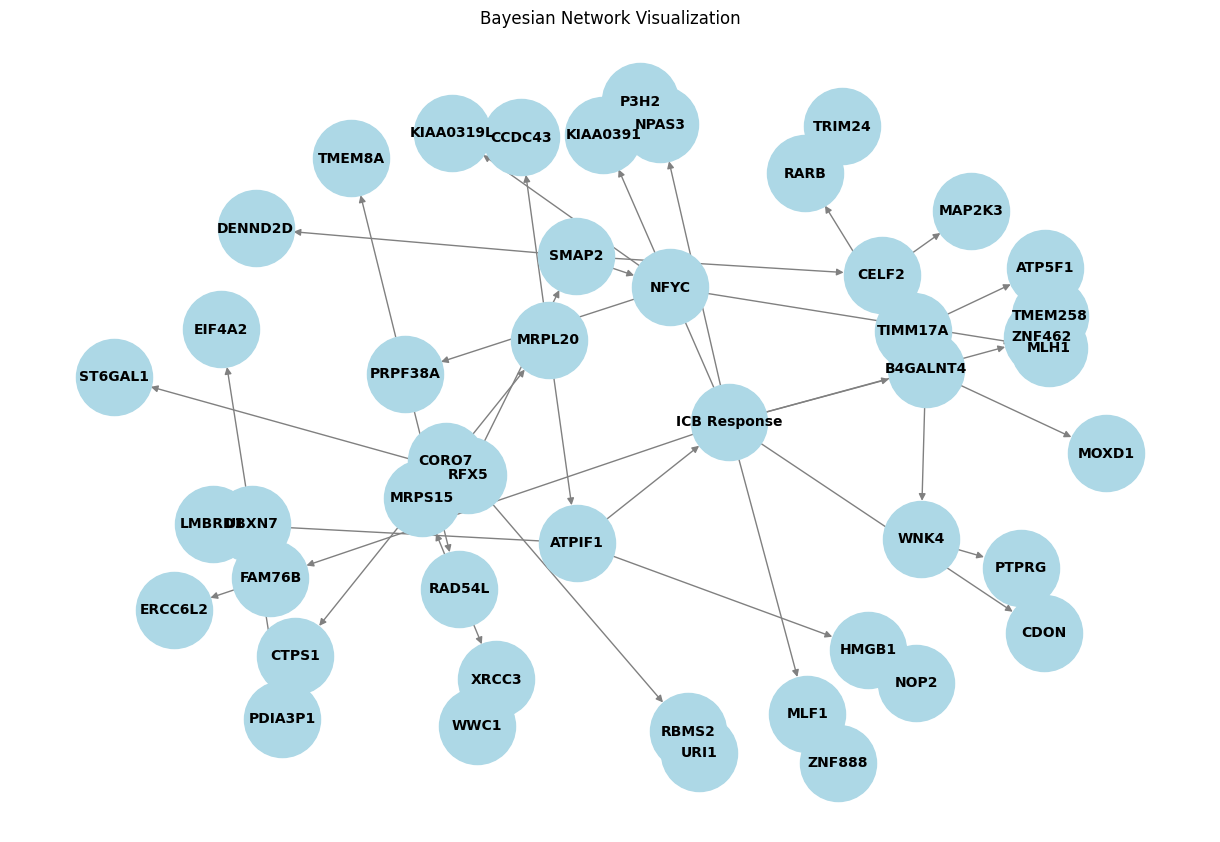

In [131]:
# Create a NetworkX graph from the Bayesian network
G = nx.DiGraph()
G.add_edges_from(best_model.edges())

# Draw the graph
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
pos = nx.spring_layout(G)  # Layout for the nodes

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")

# Display the graph
plt.title("Bayesian Network Visualization")
plt.savefig('Bayes_network.png')
plt.show()

In [141]:
edges_list = [edge for edge in best_model.edges()]
edges_df = pd.DataFrame(edges_list, columns=['Gene 1', 'Gene 2'])
edges_df.to_csv('gene_interactions.tsv', sep='\t', index=False)

In [144]:
# Initialize a list to store edge data
edge_data = []

# Iterate over each edge
for parent, child in best_model.edges:
    # Get the CPT for the child node
    cpt = model.get_cpds(node=child)

    # Calculate a measure of influence, e.g., range of probabilities
    influence_measure = cpt.values.ptp()  # Example: peak-to-peak (max-min) of the probabilities

    # Append to the edge data
    edge_data.append((parent, child, influence_measure))

# Convert to DataFrame
edges_df = pd.DataFrame(edge_data, columns=['Gene 1', 'Gene 2', 'Association Strength'])

edges_df.to_csv('gene_interactions_strength_quantified.tsv', sep='\t', index=False)